In [1]:
import numpy as np
import random as rn
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
# Map
map_size = np.array([0, 25, 0, 25, 0, 10]) # min, max

# Building 0
building0 = {}
building0['Polygon'] = [(1*2.5,4*2.5), (6.5*2.5,4*2.5), (6.5*2.5,6*2.5), (1*2.5,6*2.5)]
building0['height'] = 10

# Building 1
building1 = {}
building1['Polygon'] = [(7*2.5,4*2.5), (10*2.5,4*2.5), (10*2.5,6*2.5), (7*2.5,6*2.5)]
building1['height'] = 10

"""# Building 2
building2 = {}
building2['Polygon'] = [(7,4), (10,4), (10,6), (7,6)]
building2['height'] = 10"""

building = {}
building['nb'] = 2
building['0'] = building0
building['1'] = building1
#building['2'] = building2

In [3]:
# Start, Goal
x0 = np.array([9*2.5, 1*2.5, 3])
xf = np.array([7*2.5, 1*2.5, 7])
tol = 1.5
trange = 1

In [4]:
# Other Settings
K = 5000 # number of verticies
dQ = 2.5 # Incremental Distance

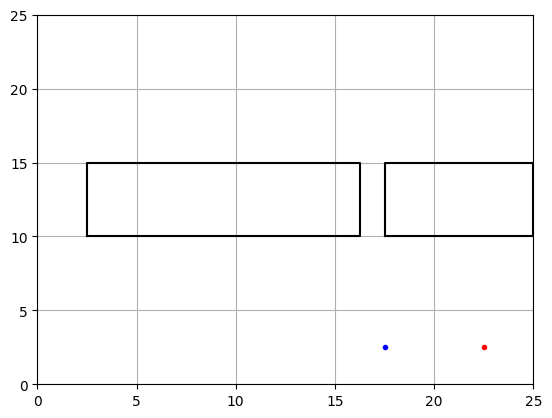

In [5]:
fig = plt.figure()
ax = plt.axes()

for nb in range(building['nb']):
    b = building[str(nb)]['Polygon']
    bx = []
    by = []
    bz = []
    for i in range(len(b)+1):
        if i < len(b):
            bx.append(b[i][0])
            by.append(b[i][1])
            bz.append(building[str(nb)]['height'])
        else:
            bx.append(b[i-len(b)][0])
            by.append(b[i-len(b)][1])
            bz.append(building[str(nb)]['height'])
    ax.plot(bx, by, '-k')

ax.plot(x0[0], x0[1], '.r')
ax.plot(xf[0], xf[1], '.b')
ax.set_xlim(map_size[0], map_size[1])
ax.set_ylim(map_size[2], map_size[3])
plt.grid()

In [6]:
import numpy as np

# Camera Model
class Camera:
    def __init__(self, cam_pos, R, thetaH, thetaV, pan, tilt):
        self.cam_position = cam_pos[0:3]    # [x, y, z], intial position at t0
        self.cam_orientation = cam_pos[3:5] # [pan, tilt], initial position at t0
        self.R = R
        self.pan = pan                      # [min, max, angular rate]
        self.tilt = tilt                    # [min, max, angular rate]
        self.thetaH = thetaH
        self.thetaV = thetaV

    def get_pos(self):
        return self.cam_position
    
    def get_h(self):
        return self.R

    def R1(self, th):
        c = np.cos(th)
        s = np.sin(th)
        return np.array([[1, 0, 0], [0, c, -s], [0, s, c]])
    
    def R2(self, th):
        c = np.cos(th)
        s = np.sin(th)
        return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])
    
    def R3(self, th):
        c = np.cos(th)
        s = np.sin(th)
        return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
    
    def get_current_pan(self, timeInstance):
        return self.cam_orientation[0] + self.pan[2]*timeInstance

    def get_current_tilt(self, timeInstance):
        return self.cam_orientation[1] + self.tilt[2]*timeInstance

    def get_direc(self, timeInstance):
        R = self.R
        direc_vec = np.array([[R], [0], [0]])

        # Assume Camera in xyz Frame
        panmin = self.pan[0]
        panmax = self.pan[1]
        panRate = self.pan[2]
        tiltmin = self.tilt[0]
        tiltmax = self.tilt[1]
        tiltRate = self.tilt[2]
        translate = self.cam_position

        # Pan angle from 0 to 360
        currPan = self.get_current_pan(timeInstance)
        if currPan > panmax:
            currPan = panmax - np.mod(currPan, panmax)
        elif currPan < panmin:
            currPan = np.mod(currPan, panmin) + panmin

        # Tilt angle from 0 to -90
        currTilt = self.get_current_tilt(timeInstance)
        if currTilt > tiltmax:
            currTilt = tiltmax - np.mod(currTilt, tiltmax)
        elif currTilt < tiltmin:
            currTilt = np.mod(currTilt, tiltmin) + tiltmin

        # Translate FOV at given timeInstance
        direc_vec = self.R3(currPan)@self.R2(currTilt)@direc_vec + np.array([[translate[0]], [translate[1]], [translate[2]]])
        return np.hstack([np.array([[translate[0]], [translate[1]], [translate[2]]]), direc_vec])

        
    def get_vertex(self, timeInstance):
        R = self.R
        thH = self.thetaH
        thV = self.thetaV

        # Compute 4 corner of FOV at given time
        vertexFOV = {}
        vertexFOV['0'] = np.array([[R], [-R*np.tan(thH/2)], [R*np.sin(thV/2)]])
        vertexFOV['1'] = np.array([[R], [-R*np.tan(thH/2)], [-R*np.sin(thV/2)]])
        vertexFOV['2'] = np.array([[R], [R*np.tan(thH/2)], [-R*np.sin(thV/2)]])
        vertexFOV['3'] = np.array([[R], [R*np.tan(thH/2)], [R*np.sin(thV/2)]])
        
        # Assume Camera in xyz Frame
        panmin = self.pan[0]
        panmax = self.pan[1]
        panRate = self.pan[2]
        tiltmin = self.tilt[0]
        tiltmax = self.tilt[1]
        tiltRate = self.tilt[2]
        translate = self.cam_position

        # Pan angle from 0 to 360
        currPan = self.cam_orientation[0] + panRate*timeInstance
        if currPan > panmax:
            currPan = panmax - np.mod(currPan, panmax)
        elif currPan < panmin:
            currPan = np.mod(currPan, panmin) + panmin

        # Tilt angle from 0 to -90
        currTilt = self.cam_orientation[1] + tiltRate*timeInstance
        if currTilt > tiltmax:
            currTilt = tiltmax - np.mod(currTilt, tiltmax)
        elif currTilt < tiltmin:
            currTilt = np.mod(currTilt, tiltmin) + tiltmin

        # Translate FOV at given timeInstance
        for i in range(4):
            vertexFOV[str(i)] = self.R3(currPan)@self.R2(currTilt)@vertexFOV[str(i)] + np.array([[translate[0]], [translate[1]], [translate[2]]])
        
        return vertexFOV
        

In [7]:
def rand_conf(rnt):
    # Random
    r = rn.uniform(0, rnt*dQ)
    theta = rn.uniform(0, 2*np.pi)
    psi = rn.uniform(0, 2*np.pi)
    #print(r)
    #print('theta, psi: '+ str(np.rad2deg(theta)) +', '+str(np.rad2deg(psi)))

    x = r*np.sin(psi)*np.cos(theta)
    y = r*np.sin(psi)*np.sin(theta)
    z = r*np.cos(psi)

    return np.array([x, y, z])

In [8]:
def nearest_vertex(qrand, G):
    num_node = len(G['node'])
    dist_vec = []
    for i in range(num_node):
        qcheck = G['node'][i]
        dq = qrand-qcheck
        dist_vec.append(np.sqrt((dq[0])**2+(dq[1])**2+(dq[2])**2))
    nearest = dist_vec.index(min(dist_vec))
    return G['node'][nearest], G['t'][nearest]

In [9]:
def inside_map(qrand):
    if qrand[0] >= map_size[0] and qrand[0] <= map_size[1] and qrand[1] >= map_size[2] and qrand[1] <= map_size[3] and qrand[2] >= map_size[4] and qrand[2] <= map_size[5]:
        return True
    else:
        return False 

In [10]:
def outside_building(qrand, building):
    qrandxy = Point(qrand[0:2])

    check_vec = []

    for nb in range(building['nb']):
        building_polygon = Polygon(building[str(nb)]['Polygon'])
        building_height = building[str(nb)]['height']
    
        if not building_polygon.contains(qrandxy) and qrand[2] >= 0 and qrand[2] <= building_height:
            check_vec.append(1)
        else:
            check_vec.append(0)

    if np.sum(check_vec) == building['nb']:
        return True
    else:
        return False

In [11]:
def distance(a, b):
    d = a - b
    return np.sqrt(d[0]**2+d[1]**2+d[2]**2)

In [12]:
def findNeighbors(G, qnew, radius):
    neighbor_vec = []

    dist_vec = []
    for i in range(len(G['node'])):
        dist_vec.append(distance(qnew, G['node'][i]))

    for i in range(len(dist_vec)):
        if dist_vec[i] <= radius:
            neighbor_vec.append(i)

    distance_vec = []
    for i in range(len(neighbor_vec)):
        distance_vec.append(distance(neighbor_vec[i], qnew))
    best_index = distance_vec.index(np.min(distance_vec))

    return G['node'][best_index], neighbor_vec

In [13]:
def outside_FOV(qrand, cam_i, timeToTest):
    cam_pos = cam_i.get_pos()
    cam_pos = np.array([[cam_pos[0]], [cam_pos[1]], [cam_pos[2]]])

    check_inside_vec = []

    # Dictionary containing planes
    # plane0 = base
    # plane1 - 4 = slant planes
    plane = {}
    plane['0'] = np.array([cam0.get_vertex(timeToTest)['0'], cam0.get_vertex(timeToTest)['1'], cam0.get_vertex(timeToTest)['2']])
    plane['1'] = np.array([cam_pos, cam0.get_vertex(timeToTest)['0'], cam0.get_vertex(timeToTest)['1']])
    plane['2'] = np.array([cam_pos, cam0.get_vertex(timeToTest)['1'], cam0.get_vertex(timeToTest)['2']])
    plane['3'] = np.array([cam_pos, cam0.get_vertex(timeToTest)['2'], cam0.get_vertex(timeToTest)['3']])
    plane['4'] = np.array([cam_pos, cam0.get_vertex(timeToTest)['3'], cam0.get_vertex(timeToTest)['0']])


    # Iterate over number of planes: 5
    for num_plane in range(5):
        p = plane[str(num_plane)]
        DA = p[1]-p[0]
        DA = np.array([DA[0][0], DA[1][0], DA[2][0]])
        CA = p[2]-p[0]
        CA = np.array([CA[0][0], CA[1][0], CA[2][0]])
        N = np.cross(DA, CA)  # Normal Vector
        if num_plane > 0:
            N = -N
        
        directionVector = np.array([p[0][0][0], p[0][1][0], p[0][2][0]]) - qrand
        value = np.dot(directionVector,N)

        check_inside_vec.append(int(value>0))

    if np.sum(check_inside_vec) == 5:
        # Inside of camera FOV
        return False
    else:
        # Outside of camera FOV
        return True

In [14]:
def new_conf(qnear, qrand, dQ, tprev, rnt):
    # get normal direction vector
    dist = qrand - qnear
    norm = np.sqrt(dist[0]**2 + dist[1]**2 + dist[2]**2)
    if not norm == 0:
        direction = dist / norm
    else:
        direction = np.zeros(3,)

    dist_travel = np.linspace(0, dQ*rnt, 1000)

    for tt in dist_travel:
        qnew = qnear + direction*tt
        if inside_map(qnew) == False or outside_building(qnew, building) == False:
            return qnew, tprev+tt
    return qnew, tprev+rnt

In [15]:
cam_pos = np.array([17.0, 15.0, 10.0, 0.0, np.deg2rad(20)])
R = 5
thetaH = np.deg2rad(54.2)
thetaV = np.deg2rad(41.7)
#thetaH = np.deg2rad(20)
#thetaV = np.deg2rad(20)

pan = np.array([np.deg2rad(0.001), 2*np.pi, np.deg2rad(10)])
tilt = np.array([np.deg2rad(-.001), np.pi/4, 0])
cam0 = Camera(cam_pos, R, thetaH, thetaV, pan, tilt)

camera = {}
num_cam = 1
camera['0'] = cam0


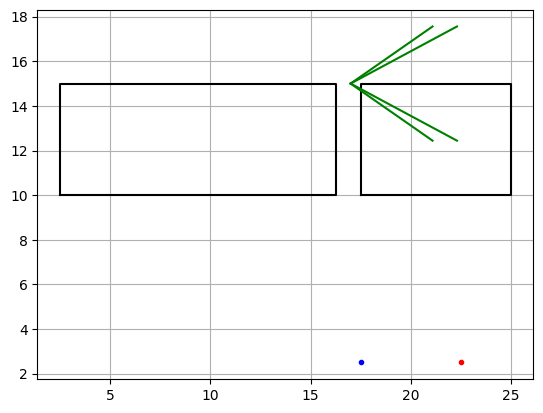

In [16]:
fig = plt.figure()
ax = plt.axes()

for nb in range(building['nb']):
    b = building[str(nb)]['Polygon']
    bx = []
    by = []
    bz = []
    for i in range(len(b)+1):
        if i < len(b):
            bx.append(b[i][0])
            by.append(b[i][1])
            bz.append(building[str(nb)]['height'])
        else:
            bx.append(b[i-len(b)][0])
            by.append(b[i-len(b)][1])
            bz.append(building[str(nb)]['height'])
    ax.plot(bx, by, '-k')

camera_vertex = cam0.get_vertex(0)
for i in range(4):
    temp = camera_vertex[str(i)]
    ax.plot([cam_pos[0], temp[0][0]], [cam_pos[1], temp[1][0]], '-g')

ax.plot(x0[0], x0[1], '.r')
ax.plot(xf[0], xf[1], '.b')
#ax.set_xlim(map_size[0], map_size[1])
#ax.set_ylim(map_size[2], map_size[3])
plt.grid()

(0.0, 10.0)

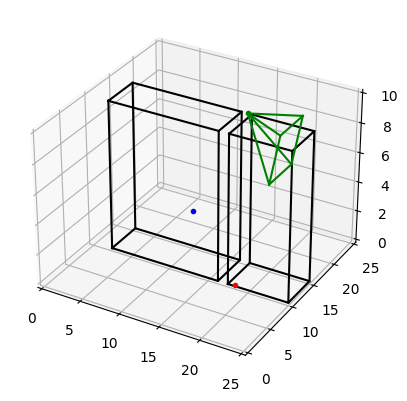

In [17]:
fig = plt.figure()
ax = plt.axes(projection='3d')

for nb in range(building['nb']):
    b = building[str(nb)]['Polygon']
    bx = []
    by = []
    bz = []
    for i in range(len(b)+1):
        if i < len(b):
            bx.append(b[i][0])
            by.append(b[i][1])
            bz.append(building[str(nb)]['height'])
        else:
            bx.append(b[i-len(b)][0])
            by.append(b[i-len(b)][1])
            bz.append(building[str(nb)]['height'])
    ax.plot3D(bx, by, bz, '-k')
    ax.plot3D(bx, by, np.zeros(len(b)+1,), '-k')
    
    for i in range(len(b)):
        ax.plot3D([bx[i], bx[i]], [by[i], by[i]], [0, building[str(nb)]['height']], '-k')

ax.plot3D(x0[0], x0[1], x0[2], '.r')
ax.plot3D(xf[0], xf[1], xf[2], '.b')
ax.plot3D(cam_pos[0], cam_pos[1], cam_pos[2], '.g')

camera_vertex = cam0.get_vertex(0)
for i in range(4):
    temp = camera_vertex[str(i)]
    
    if i == 3:
        tempt = camera_vertex[str(0)]
    else:
        tempt = camera_vertex[str(i+1)]
    ax.plot3D([cam_pos[0], temp[0][0]], [cam_pos[1], temp[1][0]], [cam_pos[2], temp[2][0]], '-g')
    ax.plot3D([temp[0][0], tempt[0][0]], [temp[1][0], tempt[1][0]], [temp[2][0], tempt[2][0]], '-g')

ax.set_xlim(map_size[0], map_size[1])
ax.set_ylim(map_size[2], map_size[3])
ax.set_zlim(map_size[4], map_size[5])

In [18]:
# RRT
G = {}
G['t'] = []
G['t'].append(0)
G['node'] = []
G['node'].append(x0)
G['edge'] = []

qprev = x0
tprev = 0
counter = 1

#for k in range(K):
while True:
    print(counter)
    # Sample Time
    rnt = rn.uniform(0.1, trange)
    currentTime = tprev + rnt

    next = True
    while next:
        # Sample new
        weight_vec = np.array([0.8, 0.1])
        weight = rn.uniform(0, 0.8)

        if weight <= weight_vec[0]:
            #print('Random')
            qrand = rand_conf(rnt) + qprev
        elif weight > weight_vec[0] and weight <= (weight_vec[0] + weight_vec[1]):
            #print('To Final Point')
            dq = xf - qprev
            norm = np.sqrt(dq[0]**2 + dq[1]**2 + dq[2]**2)
            direc = dq/norm*dQ*rnt
            qrand = qprev + direc
        else:
            qrand = qprev

        camera_check_vec = []
        for nc in range(num_cam):
            cam_i = camera[str(nc)]
            camera_check_vec.append(outside_FOV(qrand, cam_i, currentTime))

        if inside_map(qrand) == True and outside_building(qrand, building) == True and np.sum(camera_check_vec) == num_cam:
            next = False
            break

    qnear, tnear = nearest_vertex(qrand, G)
    qnew, tnew = new_conf(qnear, qrand, dQ, tprev, rnt)
    
    # Rewiring
    qnew_cost = distance(qnew, qnear)
    radius = 100
    qbest, qneighbors = findNeighbors(G, qnew, radius)
    G['edge'].append((qnew, qbest))
    
    old_cost = distance(G['node'][qneighbors[0]], qnear)
    for q in qneighbors:
        neighbor = G['node'][q]
        new_cost = qnew_cost + distance(qnew, neighbor)
        if new_cost < old_cost:
            old_cost = qnew_cost + distance(qnew, neighbor)
            G['edge'].append((qnew, neighbor))

    G['node'].append(qnew)
    G['edge'].append((qnear, qnew))
    G['t'].append(tnew)
    qprev = qnew
    tprev = tnew
    counter += 1
    
    # Check if final point reached
    dq = qnew - xf
    dist = np.sqrt(dq[0]**2+dq[1]**2+dq[2]**2)
    #print(dist)
    if dist <= tol:
        print('Destination Reached')
        break

    if counter == 500:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
Destination Reached


In [19]:
print(G['edge'][-1][1])
print(xf)
print(G['node'][0] - xf)

[17.74726668  1.87320397  6.83555157]
[17.5  2.5  7. ]
[ 5.  0. -4.]


In [20]:
#Finding Path from xf

xcheck = G['edge'][-1][1]
kounter = 0
path = []
path.append(xf)
while True:
    Gnode = G['node']
    Gedge = G['edge']

    dist_check_vec = []
    for i in range(len(Gnode)):
        dx = Gnode[i] - xcheck
        dist_check = np.sqrt(dx[0]**2 + dx[1]**2 + dx[2]**2)
        dist_check_vec.append(dist_check)
    closest = dist_check_vec.index(min(dist_check_vec))
    xcheck = Gedge[closest-1][0]
    path.append(xcheck)
    kounter += 1

    if xcheck[0] == x0[0] and xcheck[1] == x0[1] and xcheck[2] == x0[2]:
        break

print(path)

[array([17.5,  2.5,  7. ]), array([20.17771343,  3.86899832,  5.75178317]), array([20.77590348,  4.52937862,  2.75939223]), array([20.97794732,  5.29996   ,  2.68032035]), array([22.5,  2.5,  3. ])]


In [21]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

(0.0, 10.0)

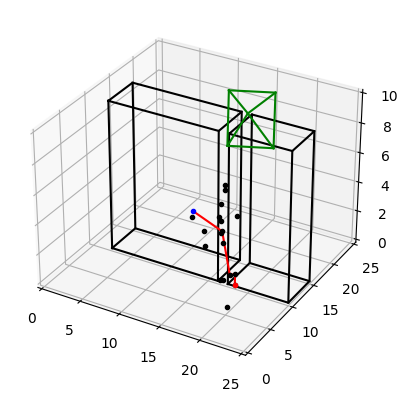

In [22]:
fig = plt.figure()
ax = plt.axes(projection='3d')

for nb in range(building['nb']):
    b = building[str(nb)]['Polygon']
    bx = []
    by = []
    bz = []
    for i in range(len(b)+1):
        if i < len(b):
            bx.append(b[i][0])
            by.append(b[i][1])
            bz.append(building[str(nb)]['height'])
        else:
            bx.append(b[i-len(b)][0])
            by.append(b[i-len(b)][1])
            bz.append(building[str(nb)]['height'])
    ax.plot3D(bx, by, bz, '-k')
    ax.plot3D(bx, by, np.zeros(len(b)+1,), '-k')
    
    for i in range(len(b)):
        ax.plot3D([bx[i], bx[i]], [by[i], by[i]], [0, building[str(nb)]['height']], '-k')

if path is not None:
    for kkk in range(len(path)-1):
        ax.plot3D([path[kkk][0], path[kkk+1][0]], [path[kkk][1], path[kkk+1][1]], [path[kkk][2], path[kkk+1][2]], '-r')


for kk in range(len(G['node'])):
    qcurr = G['node'][kk]
    ax.plot3D(qcurr[0], qcurr[1], qcurr[2], '.k')

camera_vertex = cam0.get_vertex(currentTime)
for i in range(4):
    temp = camera_vertex[str(i)]
    
    if i == 3:
        tempt = camera_vertex[str(0)]
    else:
        tempt = camera_vertex[str(i+1)]
    ax.plot3D([cam_pos[0], temp[0][0]], [cam_pos[1], temp[1][0]], [cam_pos[2], temp[2][0]], '-g')
    ax.plot3D([temp[0][0], tempt[0][0]], [temp[1][0], tempt[1][0]], [temp[2][0], tempt[2][0]], '-g')

ax.plot3D(x0[0], x0[1], x0[2], '.r')
ax.plot3D(xf[0], xf[1], xf[2], '.b')
ax.set_xlim(map_size[0], map_size[1])
ax.set_ylim(map_size[2], map_size[3])
ax.set_zlim(map_size[4], map_size[5])

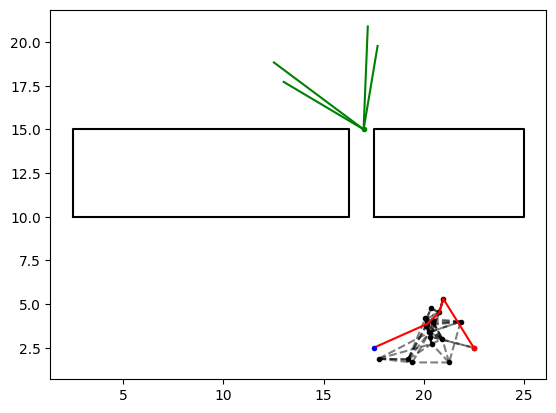

In [23]:
fig = plt.figure()
ax = plt.axes()

for nb in range(building['nb']):
    b = building[str(nb)]['Polygon']
    bx = []
    by = []
    for i in range(len(b)+1):
        if i < len(b):
            bx.append(b[i][0])
            by.append(b[i][1])
        else:
            bx.append(b[i-len(b)][0])
            by.append(b[i-len(b)][1])
    ax.plot(bx, by, '-k')
    
for kk in range(len(G['node'])):
    qcurr = G['node'][kk]
    ax.plot(qcurr[0], qcurr[1], '.k')
for kk in range(len(G['edge'])):
    edgecurr = G['edge'][kk]
    ax.plot([edgecurr[0][0], edgecurr[1][0]], [edgecurr[0][1], edgecurr[1][1]], '--k', alpha=0.5)

if path is not None:
    for kkk in range(len(path)-1):
        ax.plot([path[kkk][0], path[kkk+1][0]], [path[kkk][1], path[kkk+1][1]], '-r')

camera_vertex = cam0.get_vertex(currentTime)
for i in range(4):
    temp = camera_vertex[str(i)]
    
    if i == 3:
        tempt = camera_vertex[str(0)]
    else:
        tempt = camera_vertex[str(i+1)]
    ax.plot([cam_pos[0], temp[0][0]], [cam_pos[1], temp[1][0]], '-g')

ax.plot(cam_pos[0], cam_pos[1], '.g')
ax.plot(x0[0], x0[1], '.r')
ax.plot(xf[0], xf[1], '.b')
#ax.set_xlim(map_size[0], map_size[1])
#ax.set_ylim(map_size[2], map_size[3])

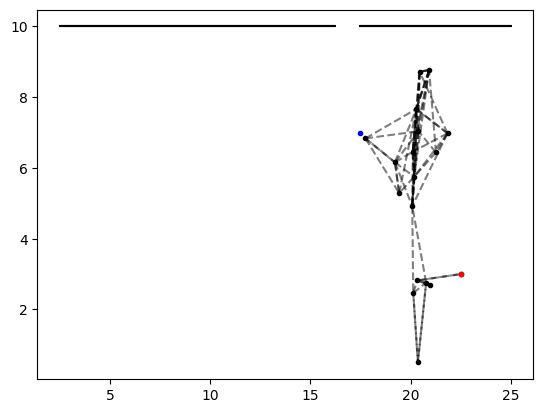

In [24]:
fig = plt.figure()
ax = plt.axes()

for nb in range(building['nb']):
    b = building[str(nb)]['Polygon']
    bx = []
    by = []
    for i in range(len(b)+1):
        if i < len(b):
            bx.append(b[i][0])
            by.append(b[i][1])
        else:
            bx.append(b[i-len(b)][0])
            by.append(b[i-len(b)][1])
    ax.plot(bx, bz, '-k')
    
for kk in range(len(G['node'])):
    qcurr = G['node'][kk]
    ax.plot(qcurr[0], qcurr[2], '.k')
for kk in range(len(G['edge'])):
    edgecurr = G['edge'][kk]
    ax.plot([edgecurr[0][0], edgecurr[1][0]], [edgecurr[0][2], edgecurr[1][2]], '--k', alpha=0.5)

ax.plot(x0[0], x0[2], '.r')
ax.plot(xf[0], xf[2], '.b')
#ax.set_xlim(map_size[0], map_size[1])
#ax.set_ylim(map_size[2], map_size[3])

In [25]:
adfasdfasfd

NameError: name 'adfasdfasfd' is not defined

KeyboardInterrupt: 

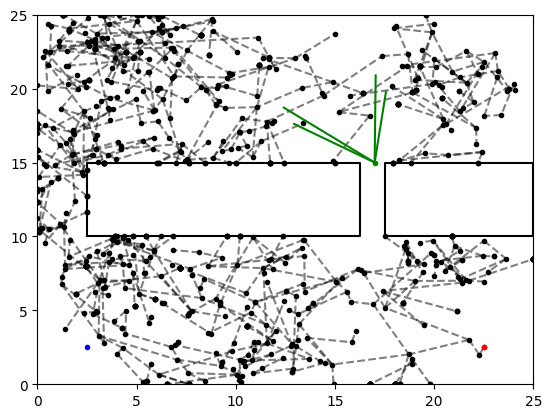

In [ ]:
import matplotlib.animation as animation

fig = plt.figure()
ax = plt.axes()

def animate(n):
    ax.clear()
    for nb in range(building['nb']):
        b = building[str(nb)]['Polygon']
        bx = []
        by = []
        for i in range(len(b)+1):
            if i < len(b):
                bx.append(b[i][0])
                by.append(b[i][1])
            else:
                bx.append(b[i-len(b)][0])
                by.append(b[i-len(b)][1])
        ax.plot(bx, by, '-k')

    for tt in range(n):
        qcurr = G['node'][tt]
        ax.plot(qcurr[0], qcurr[1], '.k')
        edgecurr = G['edge'][tt]
        ax.plot([edgecurr[0][0], edgecurr[1][0]], [edgecurr[0][1], edgecurr[1][1]], '--k', alpha=0.5)

    currentTime = G['t'][n]

    camera_vertex = cam0.get_vertex(currentTime)
    for i in range(4):
        temp = camera_vertex[str(i)]
        if i == 3:
            tempt = camera_vertex[str(0)]
        else:
            tempt = camera_vertex[str(i+1)]
        ax.plot([cam_pos[0], temp[0][0]], [cam_pos[1], temp[1][0]], '-g')

    ax.plot(cam_pos[0], cam_pos[1], '.g')
    ax.plot(x0[0], x0[1], '.r')
    ax.plot(xf[0], xf[1], '.b')
    ax.set_xlim(map_size[0], map_size[1])
    ax.set_ylim(map_size[2], map_size[3])

anim = animation.FuncAnimation(fig, animate, frames=len(G['node'])-1, interval=100)
#anim = animation.FuncAnimation(fig, animate, frames=500, interval=100)
anim.save('test.mp4')